First we generate the data the we train on. In this case a 1D burgers equation solver using a spectral fourier method. 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.integrate import solve_ivp

#Creating data by solving the burgers equation in 1D
def init_KS(x,t=0):
    u = (1+np.sin(x/10))
    return u
def Fourier_n(u, Omega,n):
    u_hat = (1j*Omega)**n*fft(u)
    u_hat = ifft(u_hat)
    return u_hat

N = 400
L = 2
x = np.linspace(-L/2, L/2, N, endpoint=False)

n = fftfreq(N)*N
scale = 2*np.pi/L
Omega = scale*n
u0 = -np.sin(np.pi*x)

def burgers(u, Omega,nu):
    #dudt = -u*Fourier_n(u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    dudt = -0.5*Fourier_n(u*u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    return np.real(dudt)

tend = 0.5
tspan = [0, tend]
nu = 0.01/np.pi
t_len = 2000
tmeasurements = np.linspace(0, tend, t_len)
sol = solve_ivp(lambda t, u: burgers(u, Omega,nu),tspan, u0, t_eval=tmeasurements)
data = sol.y.T


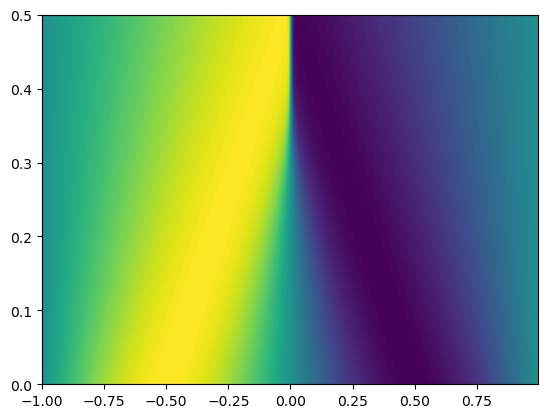

In [69]:
import numpy as np
import matplotlib.pyplot as plt
# data = np.load("burgers_solution.npy")
# x = np.load('Burgers_x.npy')
# t = np.load('Burgers_t.npy')
plt.figure()
plt.contourf(x,sol.t,data, 100, cmap="viridis")
# plt.plot(trajectory_1[:,0],trajectory_1[:,1], 'o', color = 'black', markersize = 2)
# plt.plot(trajectory_2[:,0],trajectory_2[:,1], 'o', color = 'black', markersize = 2)
plt.show()



In [101]:
x1 = -0.60
x2 = -0.05
x3 = 0.5

sensor_locs = [np.argmin(x< x1),np.argmin(x< x2),np.argmin(x< x3)]

## SHRED

Now we initialize the SHRED data setup. 

In [121]:
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig
# import pyshred
manager = DataManager(
    lags=5,          # 
    train_size=0.7,   # 80% for training We take 80% from the start 0,1,2,3... 
    val_size=0.2,     # 10% for validation Then comes val 10% from where train ends.
    test_size=0.1     # 10% for testing Lastly comes test.

)

manager.add_data(
    data=data,         # Must have time as the first index of the data. 
    id="burger",          # Unique identifier for the dataset
    # random=10,          # Randomly select 3 sensor locations
    stationary = [(sensor_locs[0],),(sensor_locs[1],),(sensor_locs[2],)],
    compress=False     # Keep original spatial resolution (no compression)
)

# Prepare the datasets and get train, val and test
train_dataset, val_dataset, test_dataset= manager.prepare()

#initialize the SHRED model
shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

DeviceConfig(device_type = 'cuda') # Set up device to use GPU


DeviceConfig(device_type='cuda', device_id=None, force_cpu=False, warn_on_fallback=True)

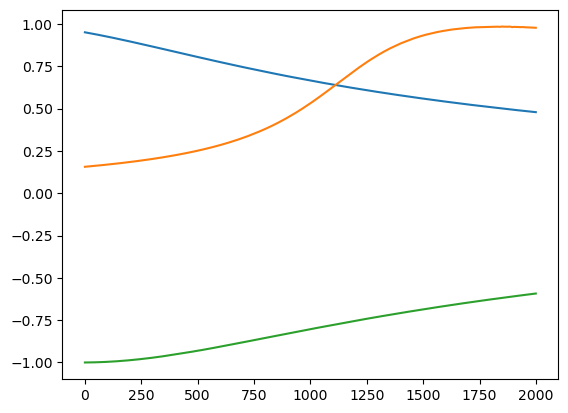

In [122]:
sensors = manager.sensor_measurements
fig, ax = plt.subplots()
# for sensor in sensors:
ax.plot(sensors[:,0])
ax.plot(sensors[:,1])
ax.plot(sensors[:,2])

In [136]:
q = 0
for X in train_dataset:
    q+=1
    if q == 500:
        print(X[0])
        print(X[1].shape)
        break
print(len(train_dataset))

tensor([[0.6136, 0.1281, 0.2320],
        [0.6128, 0.1285, 0.2328],
        [0.6120, 0.1289, 0.2335],
        [0.6112, 0.1293, 0.2343],
        [0.6104, 0.1298, 0.2351]], device='cuda:0')
torch.Size([400])
1400


# Now we fit the model!

In [ ]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=200,
    batch_size= 64,
    verbose = True,
    lr = 0.0003
)

train_mse = shred.evaluate(dataset=train_dataset) #Mse stands for mean over every element. It is the summed loss divided by the number of elements.
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Fitting SHRED...
Epoch 1: Average training loss = 0.350995
Validation MSE (epoch 1): 0.574205
Epoch 2: Average training loss = 0.309874
Validation MSE (epoch 2): 0.514305
Epoch 3: Average training loss = 0.212610
Validation MSE (epoch 3): 0.389410
Epoch 4: Average training loss = 0.111373
Validation MSE (epoch 4): 0.364337
Epoch 5: Average training loss = 0.100303
Validation MSE (epoch 5): 0.358275
Epoch 6: Average training loss = 0.096890
Validation MSE (epoch 6): 0.364472
Epoch 7: Average training loss = 0.097033
Validation MSE (epoch 7): 0.365357
Epoch 8: Average training loss = 0.096198
Validation MSE (epoch 8): 0.366354
Epoch 9: Average training loss = 0.095964
Validation MSE (epoch 9): 0.365983
Epoch 10: Average training loss = 0.095799
Validation MSE (epoch 10): 0.365777
Epoch 11: Average training loss = 0.095523
Validation MSE (epoch 11): 0.364881
Epoch 12: Average training loss = 0.095315
Validation MSE (epoch 12): 0.364099
Epoch 13: Average training loss = 0.095338
Validation

# Training complete and we move to downstream tasks.

In [105]:
engine = SHREDEngine(manager, shred) #Initialize the SHRED engine used for downstream tasks

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

# generate latent states from validation sensor measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)

# seed the forecaster with the final `seed_length` latent states from validation
init_latents = val_latents[-shred.latent_forecaster.seed_length:] # seed forecaster with final lag timesteps of latent space from val

# set forecast horizon to match the length of the test dataset
h = len(manager.test_sensor_measurements)

# forecast latent states for the test horizon
test_latent_from_forecaster = engine.forecast_latent(h=h, init_latents=init_latents)



In [106]:
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)

# decode latent space generated by the latent forecaster (generated using engine.forecast_latent())
test_forecast = engine.decode(test_latent_from_forecaster)

In [107]:
# ---------------- Train Evaluation ----------------
t_train = len(manager.train_sensor_measurements)
train_Y = {"burger": data[0:t_train]}  # Ground truth segment
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# ---------------- Validation Evaluation ----------------
t_val = len(manager.val_sensor_measurements)
val_Y = {"burger": data[t_train:t_train + t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# ---------------- Test Evaluation ----------------
t_test = len(manager.test_sensor_measurements)
test_Y = {"burger": data[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

# ---------------- Print Results ----------------
print("---------- TRAIN ----------")
print(train_error)

print("\n---------- VALIDATION ----------")
print(val_error)

print("\n---------- TEST ----------")
print(test_error)

---------- TRAIN ----------
              MSE     RMSE       MAE        R2
dataset                                       
burger   0.000125  0.01117  0.005618  0.979364

---------- VALIDATION ----------
              MSE      RMSE      MAE         R2
dataset                                        
burger   0.003547  0.059554  0.03437 -10.333738

---------- TEST ----------
              MSE      RMSE       MAE          R2
dataset                                          
burger   0.009386  0.096879  0.071115 -615.204206


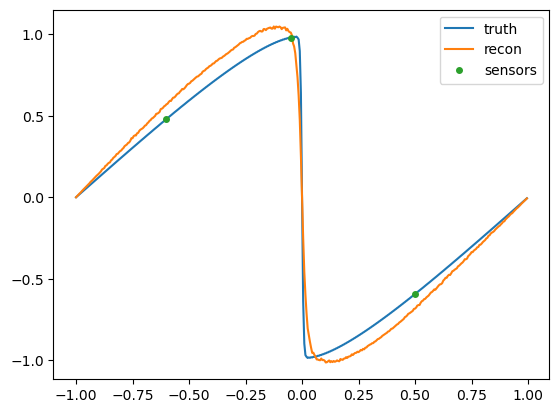

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Final ground truth frame from the test set
truth = data[-1]

# Extract final reconstructed frame (from sensor-based latents)
reconstructions = test_reconstruction["burger"]
reconstruction = reconstructions[h - 1]

# Extract final forecasted frame (from forecasted latents)
forecasts = test_forecast["burger"]
forecast = forecasts[h - 1]

# Collect data and labels for visualization
compare_data = [truth, reconstruction, forecast]
titles = ["Test Ground Truth", "SHRED Reconstruction", "SHRED Forecast"]


# Create side-by-side comparison plot
fig,ax = plt.subplots()
ax.plot(x,truth, label = 'truth')
ax.plot(x,reconstruction,label = 'recon')
# ax.plot(x,forecast,label = 'forecast')
ax.plot(x[sensor_locs],truth[sensor_locs],'o', label = 'sensors',markersize = 4)
ax.legend()

In [99]:
print(x[sensor_locs])

[-0.75 -0.5   0.5 ]
